### ML en visualisatie met Iris dataset / Iris dataset in HANA 

In [25]:
import os
import pandas as pd
import seaborn as sns
import numpy as np

from hana_ml import dataframe

from matplotlib import pyplot as plt
%matplotlib inline

conn = dataframe.ConnectionContext(address = 'hxe.richardschop.nl', port = 39015, database = 'HXE', user = 'RSCHOP', password = 'Aloha1503')

In [26]:
col_features = ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']
col_label = 'Species'
col_label_class = ['setosa', 'versicolor', 'virginica']

# Create the HANA Dataframe (df_train) and point to the training table.
training_data = conn.table(table = "IRIS", schema = "R_DATA").collect()

training_data.Species.replace(sorted(training_data.Species.unique()), col_label_class, inplace=True)

training_data.head(10)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


            Species  Species %
versicolor       50   0.333333
setosa           50   0.333333
virginica        50   0.333333
AxesSubplot(0.125,0.125;0.775x0.755)


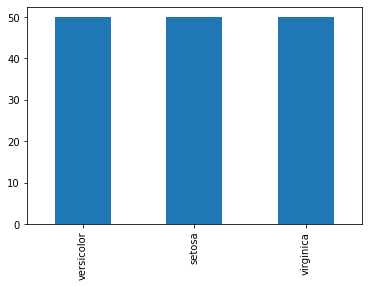

In [27]:
value_counts = training_data[col_label].value_counts()
value_counts_n = training_data[col_label].value_counts(normalize=True)
value_counts_n.rename('Species %', inplace=True)

summary = pd.concat([value_counts, value_counts_n],axis=1)

print(summary)
print(training_data[col_label].value_counts().plot(kind = 'bar'))

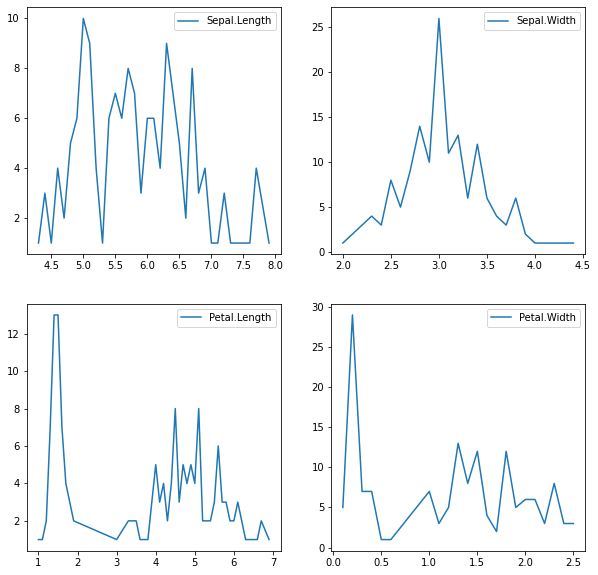

In [28]:
features_data = training_data.loc[:, col_features]
fig, axes = plt.subplots(figsize=(10,10),
    nrows=2,
    ncols=2,
)

for i, ax in enumerate(axes.flat):
    features_data[col_features[i]].value_counts().sort_index().plot(kind='line', legend=True, ax=ax)
plt.show()

In [29]:
features_data = training_data.loc[:, col_features]

df = pd.concat([
    features_data.mean(),
    features_data.median(),
    features_data.std(),
    features_data.min(),
    features_data.max(),
    features_data.min() + (features_data.max() - features_data.min()) / 2,
], axis=1)
df.columns = ['mean','med','std','min','max','mid']
print(df)

                  mean   med       std  min  max   mid
Sepal.Length  5.843333  5.80  0.828066  4.3  7.9  6.10
Sepal.Width   3.057333  3.00  0.435866  2.0  4.4  3.20
Petal.Length  3.758000  4.35  1.765298  1.0  6.9  3.95
Petal.Width   1.199333  1.30  0.762238  0.1  2.5  1.30


In [30]:
features_data = training_data.loc[:, col_features]
df = pd.concat([
    features_data[~( (features_data-features_data.median()).abs() > 3*features_data.std() )].isnull().sum(),
    features_data[~( (features_data < features_data.quantile(.25)) | (features_data > features_data.quantile(.75)) )].isnull().sum(),
], axis=1)
df.columns = ['3*std','25/75 quartile']
print(df)

              3*std  25/75 quartile
Sepal.Length      0              67
Sepal.Width       1              70
Petal.Length      0              71
Petal.Width       0              68


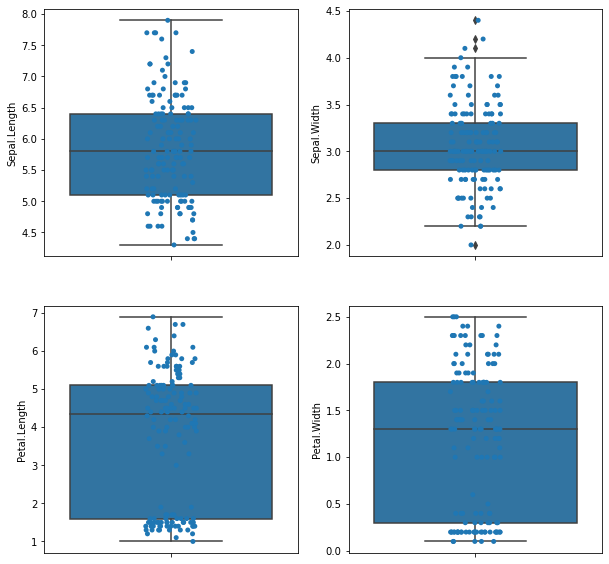

In [31]:
features_data = training_data.loc[:, col_features]

fig, axes = plt.subplots(figsize=(10,10),
    nrows=2,
    ncols=2,
)
for i, ax in enumerate(axes.flat):
    sns.boxplot(y=col_features[i], data=training_data, ax=ax)
    sns.stripplot(y=col_features[i], data=training_data, jitter=True, edgecolor="gray", ax=ax)
plt.show()

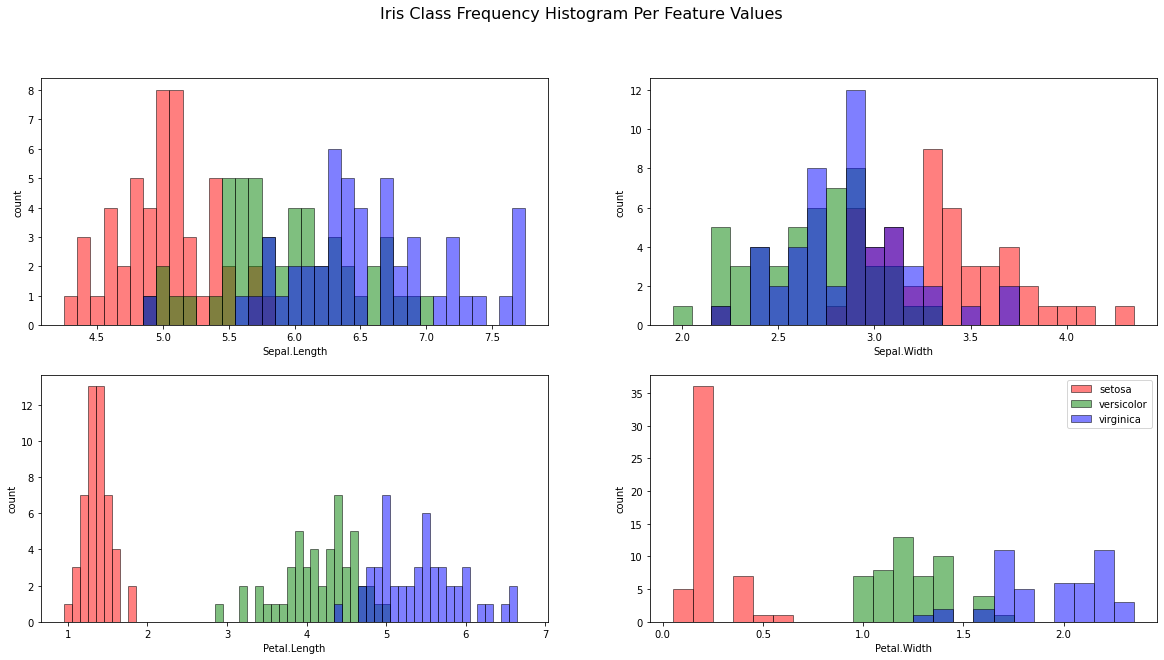

In [32]:
col_labels_class_values  = training_data.Species.unique()

fig, axes = plt.subplots(figsize=(20,10), nrows=2, ncols=2)
fig.suptitle("Iris Class Frequency Histogram Per Feature Values", fontsize=16)
colors= ['red', 'green', 'blue']

desired_bin_size = 0.1

for i, ax in enumerate(axes.flat):
    data = training_data.loc[:, col_features[i]]
    min_val = np.min(data)
    max_val = np.max(data)
    bins = np.arange(min_val, max_val, desired_bin_size)

    for idx_label, color in zip(range(len(col_label_class)), colors):
        ax.hist(
            training_data.loc[training_data.Species == col_labels_class_values[idx_label], col_features[i]],
            label = col_label_class[idx_label],
            color = color,
            alpha = 0.5,
            bins = bins,
            edgecolor='black',
            align='left',
        )
        ax.set_xlabel(col_features[i])
        ax.set_ylabel('count')
axes[1,1].legend(loc='upper right')
plt.show()

In [33]:
for idx_label in range(len(col_label_class)):
    print('\nclass {}:'.format(col_label_class[idx_label]))
    features_data = training_data.loc[training_data.Species == col_labels_class_values[idx_label], col_features]
    df = pd.concat([
        features_data.mean(),
        features_data.median(),
        features_data.std(),
        features_data.min(),
        features_data.max(),
        features_data.min() + (features_data.max() - features_data.min()) / 2,
    ], axis=1)
    df.columns = ['mean','med','std','min','max','mid']
    print(df)


class setosa:
               mean  med       std  min  max   mid
Sepal.Length  5.006  5.0  0.352490  4.3  5.8  5.05
Sepal.Width   3.428  3.4  0.379064  2.3  4.4  3.35
Petal.Length  1.462  1.5  0.173664  1.0  1.9  1.45
Petal.Width   0.246  0.2  0.105386  0.1  0.6  0.35

class versicolor:
               mean   med       std  min  max   mid
Sepal.Length  5.936  5.90  0.516171  4.9  7.0  5.95
Sepal.Width   2.770  2.80  0.313798  2.0  3.4  2.70
Petal.Length  4.260  4.35  0.469911  3.0  5.1  4.05
Petal.Width   1.326  1.30  0.197753  1.0  1.8  1.40

class virginica:
               mean   med       std  min  max   mid
Sepal.Length  6.588  6.50  0.635880  4.9  7.9  6.40
Sepal.Width   2.974  3.00  0.322497  2.2  3.8  3.00
Petal.Length  5.552  5.55  0.551895  4.5  6.9  5.70
Petal.Width   2.026  2.00  0.274650  1.4  2.5  1.95


In [34]:
for idx_label in range(len(col_label_class)):
    print('\nclass {}:'.format(col_label_class[idx_label]))
    features_data = training_data.loc[training_data.Species == col_labels_class_values[idx_label], col_features]
    df = pd.concat([
        features_data[~( (features_data-features_data.median()).abs() > 3*features_data.std() )].isnull().sum(),
        features_data[~( (features_data < features_data.quantile(.25)) | (features_data > features_data.quantile(.75)) )].isnull().sum(),
    ], axis=1)
    df.columns = ['3*std','25/75 quartile']
    print(df)


class setosa:
              3*std  25/75 quartile
Sepal.Length      0              22
Sepal.Width       0              25
Petal.Length      0              24
Petal.Width       1              14

class versicolor:
              3*std  25/75 quartile
Sepal.Length      0              22
Sepal.Width       0              21
Petal.Length      0              22
Petal.Width       0              15

class virginica:
              3*std  25/75 quartile
Sepal.Length      0              25
Sepal.Width       0              24
Petal.Length      0              22
Petal.Width       0              11


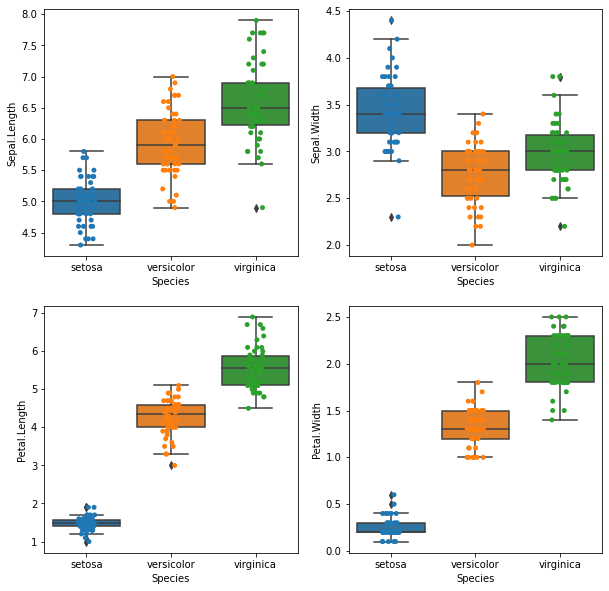

In [35]:
features_data = training_data.loc[:, col_features]

fig, axes = plt.subplots(figsize=(10,10),
    nrows=2,
    ncols=2,
)
for i, ax in enumerate(axes.flat):
    sns.boxplot(x='Species', y=col_features[i], data=training_data, ax=ax)
    sns.stripplot(x='Species',y=col_features[i], data=training_data, jitter=True, edgecolor="gray", ax=ax)
plt.show()

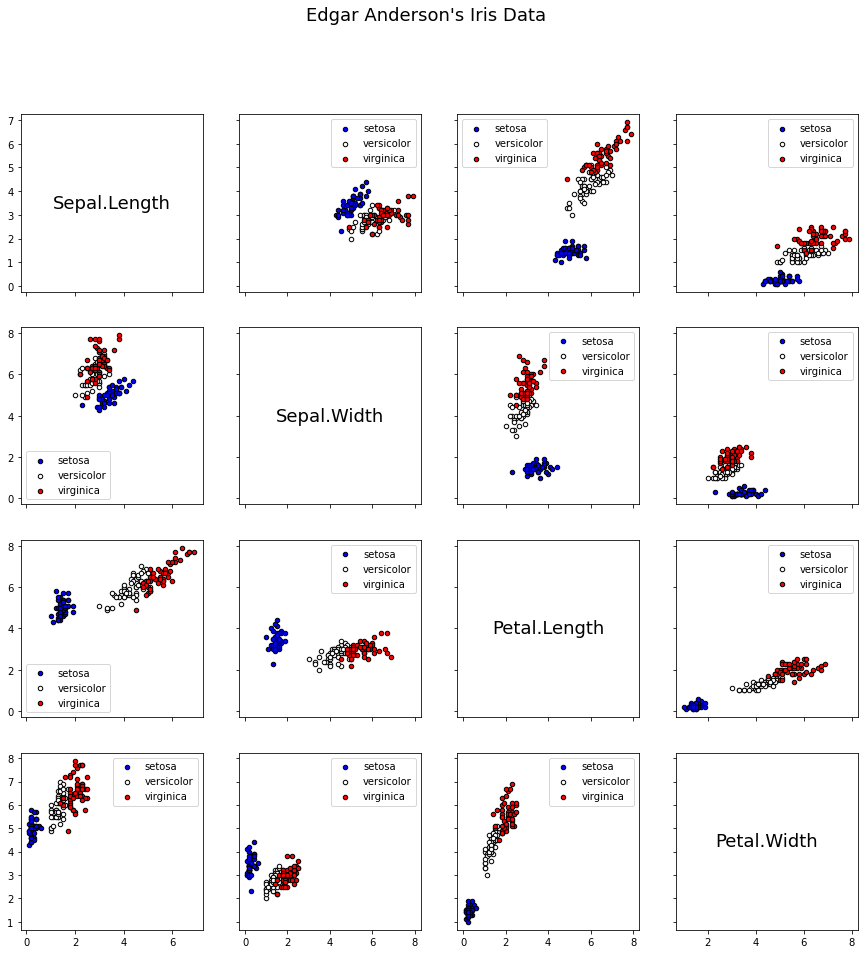

In [36]:
fig, axes = plt.subplots(figsize=(15,15),
    nrows=len(col_features),
    ncols=len(col_features),
    sharex='col',
    sharey='row'
)
fig.suptitle("Edgar Anderson's Iris Data", fontsize=18)
plot_colors = ['blue', 'white', 'red']

for x in range(len(col_features)):
    for y in range(len(col_features)):
        ax = axes[x,y]
        if x == y:
            ax.text(0.5, 0.5, col_features[x],
                transform = ax.transAxes,
                horizontalalignment = 'center',
                verticalalignment = 'center',
                fontsize = 18
            )
        else:
            for idx_label, color in zip(range(len(col_label_class)), plot_colors):
                idx = np.where(training_data.Species == idx_label)                
                ax.scatter(
                    training_data.loc[training_data.Species == col_labels_class_values[idx_label], col_features[x]],
                    training_data.loc[training_data.Species == col_labels_class_values[idx_label], col_features[y]],
                    c = color,
                    cmap = plt.cm.RdYlBu,
                    label = col_labels_class_values[idx_label],
                    edgecolor = 'black',
                    s = 20
                )
                ax.legend()
plt.show()